In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [225]:
cd /content/drive/MyDrive/DIGITAL-WATERMARKING-PROJECT/Mayuk

/content/drive/MyDrive/DIGITAL-WATERMARKING-PROJECT/Mayuk


In [226]:
ls

baboon-color.jpg  watermark-embedding-extraction-color-baboon.ipynb
baboon.jpg        Watermark-embedding-extraction-gray-baboon.ipynb
leena-color.png   Watermark-embedding-extraction-gray-leena.ipynb
Lena-gray.png     watermark-embeding-extraction-for-color-Leena.ipynb


# 1. Reversible Watermark generation and embedding

In [227]:
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import pywt
from PIL import Image

In [228]:
leena = cv2.imread('leena-color.png')
gray_leena = cv2.cvtColor(leena, cv2.COLOR_BGR2GRAY)

In [229]:
print(gray_leena.shape)
print(leena.shape)

(512, 512)
(512, 512, 3)


In [230]:
def haar_wavelet_transform(block):
    # Apply Haar wavelet transform
    LL, (LH, HL, HH) = pywt.dwt2(block, 'haar')
    return LL, LH, HL, HH

def reverse_haar_wavelet_transform(LL, LH, HL, HH):
    # Combine LL, LH, HL, and HH to reconstruct the original block
    block = np.zeros((2, 2))
    block[0, 0] = LL
    block[0, 1] = LH
    block[1, 0] = HL
    block[1, 1] = HH
    block_tuple = (np.array([[LL]]), (np.array([[LH]]), np.array([[HL]]), np.array([[HH]])))
    # Apply inverse Haar wavelet transform
    return pywt.idwt2(block_tuple, 'haar')

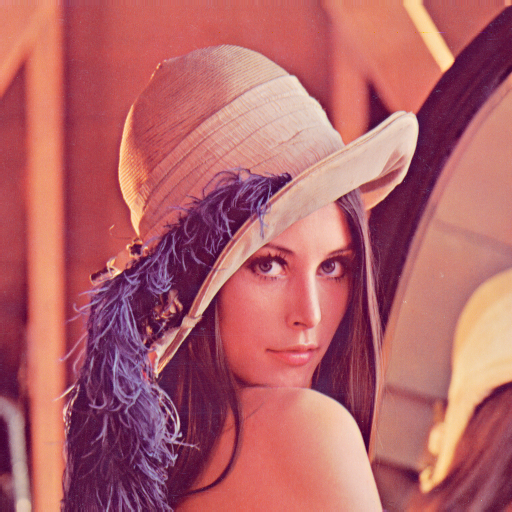

In [231]:
cv2_imshow(leena)

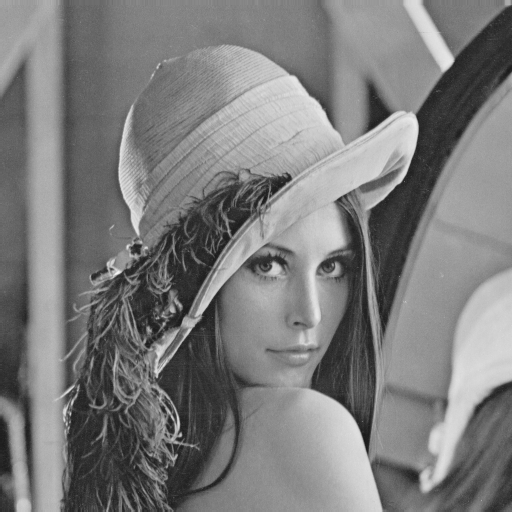

In [232]:
cv2_imshow(gray_leena)

# Once it converted into gray scale image Rest procedure is similar to gray image

In [233]:

# apply wavelet transformation on each block of the image
def process_image(image):
    height, width = image.shape
    new_image = np.zeros((height, width))

    # Ensure the image dimensions are even for easy block division
    if height % 2 != 0:
        height -= 1
    if width % 2 != 0:
        width -= 1

    for y in range(0, height, 2):
        for x in range(0, width, 2):
            block = image[y:y+2, x:x+2]
            LL, LH, HL, HH = haar_wavelet_transform(block)
            # Replace pixel values of the block with subbands
            new_image[y, x] = LL  # Replace top-left pixel with LL subband
            new_image[y, x+1] = LH  # Replace top-right pixel with LH subband
            new_image[y+1, x] = HL  # Replace bottom-left pixel with HL subband
            new_image[y+1, x+1] = HH  # Replace bottom-right pixel with HH subband

    return new_image

In [234]:
# apply reverse wavelet transformation on each block of the image
def reverse_process_image(image):
    height, width = image.shape
    original_image = np.zeros((height, width))

    for y in range(0, height, 2):
        for x in range(0, width, 2):
            LL = image[y, x]
            LH = image[y, x+1]
            HL = image[y+1, x]
            HH = image[y+1, x+1]
            block = reverse_haar_wavelet_transform(LL, LH, HL, HH)
            original_image[y:y+2, x:x+2] = block

    return original_image

<ipython-input-233-659b0ffcd630>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y, x] = LL  # Replace top-left pixel with LL subband
<ipython-input-233-659b0ffcd630>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y, x+1] = LH  # Replace top-right pixel with LH subband
<ipython-input-233-659b0ffcd630>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y+1, x] = HL  # Replace bottom-left pixel with HL subband
<ipython-input-233-659b

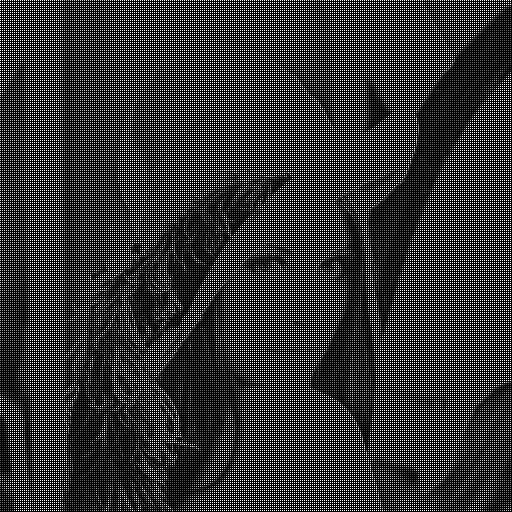

In [235]:
# apply wavelet transformation on each 2*2 block of the image
t_leena = process_image(gray_leena)
cv2_imshow(t_leena)

In [236]:
# divide the entire matrix into blocks of 2*2 size
def divide_into_blocks(matrix):
    height, width = matrix.shape
    blocks = []
    for y in range(0, height, 2):
        for x in range(0, width, 2):
            blocks.append(matrix[y:y+2, x:x+2])
    return blocks


# after performing operation combine all the blocks into the matrix
def combine_blocks(blocks, matrix_shape):
    height, width = matrix_shape
    matrix = np.zeros(matrix_shape)
    index = 0
    for y in range(0, height, 2):
        for x in range(0, width, 2):
            matrix[y:y+2, x:x+2] = blocks[index]
            index += 1
    return matrix

In [237]:
# randomly shuffle all the blocks in the matrix
def shuffle_blocks(blocks, key_string):
    np.random.seed(sum(ord(c) for c in key_string))
    shuffled_indices = np.random.permutation(len(blocks))
    return [blocks[i] for i in shuffled_indices], shuffled_indices

# get the original matrix in correct order
def unshuffle_blocks(shuffled_blocks, shuffled_indices):
    unshuffled_blocks = [None] * len(shuffled_blocks)
    for i, block in enumerate(shuffled_blocks):
        unshuffled_blocks[shuffled_indices[i]] = block
    return unshuffled_blocks

In [238]:
P = t_leena
# Divide matrix P into 2x2 blocks
blocks = divide_into_blocks(P)

# Shuffle blocks using a key string
key_string = "jD5r9H3pTcVuXzW6GvYtQx8P4eN1b2Sa"
shuffled_blocks, shuffled_indices = shuffle_blocks(blocks, key_string)

# Reverse the shuffle
unshuffled_blocks = unshuffle_blocks(shuffled_blocks, shuffled_indices)

# Reconstruct the original matrix P
reconstructed_P = combine_blocks(unshuffled_blocks, P.shape)

_p = combine_blocks(shuffled_blocks, P.shape)
_p= shuffled_blocks

In [239]:
pz = [] # integer matrix
pf = [] # decimal matrix

# Iterate over each block in _p
for block in _p:
    # Extract integer and decimal parts
    integer_part = np.array(block, dtype=int)
    decimal_part = block - integer_part

    # Append integer and decimal parts to respective lists
    pz.append(integer_part)
    pf.append(decimal_part)

In [240]:

# authentication watermark generation ...
def average_of_msb_block(block):
    # Calculate absolute values of each number divided by 16
    abs_values_divided_by_16 = [abs(value // 16) for row in block for value in row]

    # Calculate the sum of absolute values divided by 16
    sum_of_abs_values_divided_by_16 = sum(abs_values_divided_by_16)

    # Calculate the average of the sum
    average_of_abs_values_divided_by_16 = sum_of_abs_values_divided_by_16 // 4

    # Convert the average to binary and ensure it's exactly 4 bits
    average_binary = bin(average_of_abs_values_divided_by_16 & 0b1111)[2:].zfill(4)
    return average_binary

In [241]:
# feature-recovery watermark generation ...
def feature_watermark(matrix):
    n = len(matrix)
    m = len(matrix[0])

    if n != 2 or m != 2:
        return -1

    arr = []
    cnt = 1

    for i in range(n):
        for j in range(m):
            arr.append((matrix[i][j], cnt))
            cnt += 1

    arr.sort()

    highval = arr[3][0] + arr[2][0]
    lowval = arr[0][0] + arr[1][0]
    diff = highval - lowval

    ans = 0

    if diff < 3:
        ans = 0
    else:
        highidx1 = arr[3][1]
        highidx2 = arr[2][1]

        if highidx1 > highidx2:
            highidx1, highidx2 = highidx2, highidx1  # swap

        if highidx1 == 3 and highidx2 == 4:
            ans = 1
        elif highidx1 == 2 and highidx2 == 4:
            ans = 2
        elif highidx1 == 1 and highidx2 == 3:
            ans = 3
        elif highidx1 == 1 and highidx2 == 2:
            ans = 4
        elif highidx1 == 1 and highidx2 == 4:
            ans = 5
        elif highidx1 == 2 and highidx2 == 3:
            ans = 6

    finalans = ans * 32 + diff
    # Convert finalans to 8-bit binary format
    return format(finalans % 256, '08b')

In [242]:

# replacing the bits in pixel values of each block ...
def replace_lsb_with_result_bit(block, result_bits, watermark_bits):
  aw=0
  fw=0
  for i in range(0,2):  # Iterating in reverse for 0001 order
    for j in range(0,2):
      temp = format(block[i][j],'08b')
      s_list = list(temp)
      s_list[7] = result_bits[aw]
      s_list[5] = watermark_bits[fw]
      s_list[6] = watermark_bits[fw+1]
      aw +=1
      fw +=2
      temp = ''.join(s_list)
      block[i][j] = int(temp, 2)
  return block



In [243]:

# main embedding function in integer matrix ..
def embed_auth_watermark(blocks):
    processed_blocks = []
    for block in blocks:
        # Calculate the average of the absolute values divided by 16 and convert to 4-bit binary
        result = average_of_msb_block(block)
        # print(result)
        fwb = feature_watermark(block)
        # print(fwb)
        # Replace LSB of each value with bits from the result
        modified_block = replace_lsb_with_result_bit(block, result,fwb)
        processed_blocks.append(modified_block)
    return processed_blocks

In [244]:
# embed the watermark bits into integer matrix
_pz=embed_auth_watermark(pz)

In [245]:
from decimal import Decimal, getcontext

# Set the precision for Decimal calculations
getcontext().prec = 10  # Set to the desired precision

# after embedding add integer and the decimal matrix ...
def add_blocks(block_list1, block_list2):
    # Check if the dimensions of the two block lists are compatible
    if len(block_list1) != len(block_list2) or len(block_list1[0]) != len(block_list2[0]):
        return "Error: The dimensions of the two block lists are not compatible."

    # Initialize an empty result list
    result = []

    # Iterate over each block in the block lists and add corresponding elements
    for i in range(len(block_list1)):
        row = []
        for j in range(len(block_list1[0])):
            # Convert input blocks to floats
            block1_float = [float(num) for num in block_list1[i][j]]
            block2_float = [float(num) for num in block_list2[i][j]]

            # Add corresponding elements from each block using Decimal
            block_sum = []
            for k in range(len(block1_float)):
                block_sum.append(block1_float[k] + block2_float[k])
            row.append(block_sum)
        result.append(row)

    return result

In [246]:
# inverse wavelet transformation during extraction ...
def reverse_process_image2(currimage, watermarkImage):
    height, width = currimage.shape
    extractimage = np.zeros((height, width))

    for y in range(0, height, 2):
        for x in range(0, width, 2):
            LL = currimage[y, x]
            LH = currimage[y, x+1]
            HL = currimage[y+1, x]
            HH = currimage[y+1, x+1]
            block = reverse_haar_wavelet_transform(LL, LH, HL, HH)
            extractimage[y:y+2, x:x+2] = block
    extractimage = watermarkImage
    return extractimage

In [247]:
block_list1 = _pz
block_list2 = pf

# Add the blocks of integer and decimal matrix after embedding
__p = add_blocks(block_list1, block_list2)

In [248]:
# reverse shuffling after embedding
unshuffled_blocks = unshuffle_blocks(__p, shuffled_indices)

# convert the tupple of blocks into the matrix
reconstructed__P = combine_blocks(unshuffled_blocks, P.shape)

In [249]:
# use inverse wavelet transformation
_o = reverse_process_image(reconstructed__P)

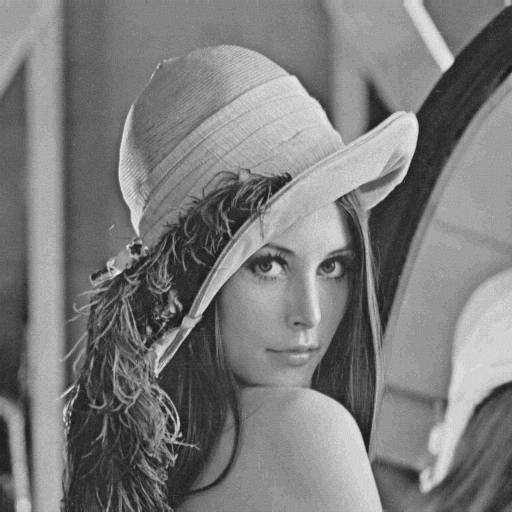

In [250]:
# final watermark image
cv2_imshow(_o)


# PSNR & NCC Values between 2 images

In [251]:
# calculate psnr between cover image and watermarked image
def psnr_grayscale(img1, img2):
    # Add channel dimension if it doesn't exist (for grayscale images)
    if len(img1.shape) == 2:
        img1 = np.expand_dims(img1, axis=-1)
    if len(img2.shape) == 2:
        img2 = np.expand_dims(img2, axis=-1)

    # Convert images to float32
    img1 = np.float32(img1)
    img2 = np.float32(img2)

    # Calculate squared difference
    diff = img1 - img2
    squared_diff = diff ** 2

    # Calculate MSE (Mean Squared Error)
    mse = np.mean(squared_diff)

    # Calculate PSNR
    if mse == 0:
        psnr_val = float('inf')
    else:
        max_pixel_value = 255.0
        psnr_val = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr_val

In [252]:
psnr_grayscale(gray_leena,_o)

36.43433205263108

In [253]:
# comparison of NCC between 2 images
def normalize(image):
    """
    Normalize the image to have zero mean and unit variance.
    """
    return (image - np.mean(image)) / np.std(image)

def ncc(image1, image2):
    """
    Calculate the normalized cross-correlation (NCC) between two images.
    """
    # Normalize the images
    image1_normalized = normalize(image1)
    image2_normalized = normalize(image2)

    # Compute the cross-correlation
    cross_correlation = np.correlate(image1_normalized.flatten(), image2_normalized.flatten())

    # Compute the normalization factor
    normalization_factor = np.sqrt(np.sum(image1_normalized**2) * np.sum(image2_normalized**2))

    # Calculate the NCC
    ncc_value = cross_correlation / normalization_factor

    return ncc_value

In [254]:
# NCC between the original image and watermark image
ncc(gray_leena,_o)


array([0.99678702])

# 2. Reversible watermark extraction

<ipython-input-233-659b0ffcd630>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y, x] = LL  # Replace top-left pixel with LL subband
<ipython-input-233-659b0ffcd630>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y, x+1] = LH  # Replace top-right pixel with LH subband
<ipython-input-233-659b0ffcd630>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  new_image[y+1, x] = HL  # Replace bottom-left pixel with HL subband
<ipython-input-233-659b

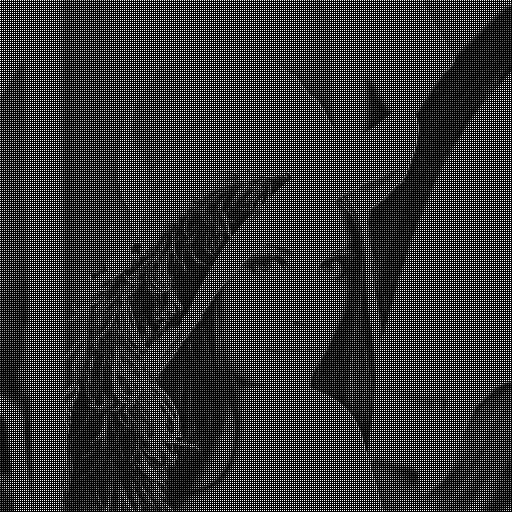

In [255]:
# apply wavelet transformation on each 2*2 block of the watermarked image
t_leena2 = process_image(_o)
cv2_imshow(t_leena2)

In [256]:
P2 = t_leena2
# Divide matrix P into 2x2 blocks
blocks2 = divide_into_blocks(P2)

# Shuffle blocks using a key string
key_string = "jD5r9H3pTcVuXzW6GvYtQx8P4eN1b2Sa"
shuffled_blocks2, shuffled_indices2 = shuffle_blocks(blocks2, key_string)

# Reverse the shuffle
unshuffled_blocks2 = unshuffle_blocks(shuffled_blocks2, shuffled_indices2)

# Reconstruct the original matrix P
reconstructed_P2 = combine_blocks(unshuffled_blocks2, P2.shape)

_p = combine_blocks(shuffled_blocks, P.shape)
_p2= shuffled_blocks

In [257]:
pz2 = [] # integer matrix for watermarked image
pf2 = [] # decimal matrix for watermarked image

# Iterate over each block in _p2
for block in _p2:
    # Extract integer and decimal parts
    integer_part = np.array(block, dtype=int)
    decimal_part = block - integer_part

    # Append integer and decimal parts to respective lists
    pz2.append(integer_part)
    pf2.append(decimal_part)

In [258]:
# extracting the authentication watermark ..
def extract_auth_watermark(block):
    auth_watermark = ''
    for i in range(2):  # Iterating over 4 pixels
        for j in range(2):
            pixel_value_binary = format(block[i][j], '08b')  # Convert pixel value to binary string
            auth_watermark += pixel_value_binary[-1]  # Take the last bit of each pixel value
    return auth_watermark


# extracting the feature watermark ..
def extract_feature_watermark(block):
    feature_watermark = ''
    for i in range(2):  # Iterating over 4 pixels
        for j in range(2):
            pixel_value_binary = format(block[i][j], '08b')  # Convert pixel value to binary string
            feature_watermark += pixel_value_binary[-3:-1]  # Take the 2nd and 3rd bits of each pixel value
    return feature_watermark



In [259]:
def extract_watermarked_blocks(processed_blocks):
    extracted_blocks = []
    for block in processed_blocks:
        auth_watermark_old = average_of_msb_block(block)  # Get the previously obtained authentication watermark
        feature_watermark_old = feature_watermark(block)  # Get the previously obtained feature watermark

        auth_watermark_new = extract_auth_watermark(block)  # Extract authentication watermark from the block
        feature_watermark_new = extract_feature_watermark(block)  # Extract feature watermark from the block

        # Compare the extracted watermarks with the previously obtained ones
        if auth_watermark_new == auth_watermark_old :
            # If both watermarks match, make the block 0
            extracted_blocks.append(block)
        else:
            # If watermarks don't match, make the block dark (set all values to 0)
            extracted_blocks.append([[255, 255], [255, 255]])
    return extracted_blocks

In [260]:
# embed the watermark bits into integer matrix
_pz2=extract_watermarked_blocks(pz2)

In [261]:
# Add the blocks of integer and decimal matrix after embedding
__p2 = add_blocks(_pz2, pf2)

In [262]:
# reverse shuffling after embedding
unshuffled_blocks2 = unshuffle_blocks(__p2, shuffled_indices2)

# convert the tupple of blocks into the matrix
reconstructed__P2 = combine_blocks(__p2, P2.shape)

In [263]:
# use inverse wavelet transformation
_o2 = reverse_process_image2(reconstructed__P2,_o)

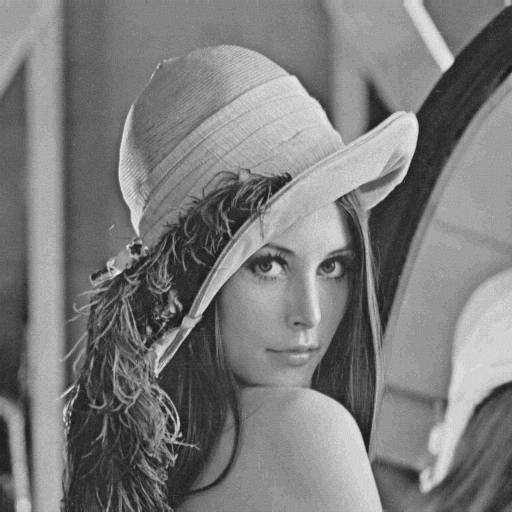

In [264]:
# final watermark extracted image ...
cv2_imshow(_o2)

In [265]:
# psnr between watermark extracted image and the original image
psnr_grayscale(_o,_o2)

inf

# 3. Detection of Tampered Areas

In [266]:
def apply_mean_attack(image):
    attacked_image = np.copy(image)  # Create a copy of the original image
    attacked_coordinates = []  # Initialize list to store attacked pixel coordinates

    # Get image dimensions
    height, width = image.shape

    # Apply mean attack on 5000 randomly selected positions
    for _ in range(5000):
        # Randomly select a position
        x = np.random.randint(0, width)
        y = np.random.randint(0, height)

        # Define a random neighborhood size (odd number)
        neighborhood_size = np.random.choice([3, 5, 7])

        # Calculate the neighborhood bounds
        x_start = max(0, x - neighborhood_size // 2)
        x_end = min(width, x + neighborhood_size // 2 + 1)
        y_start = max(0, y - neighborhood_size // 2)
        y_end = min(height, y + neighborhood_size // 2 + 1)

        # Extract the neighborhood
        neighborhood = image[y_start:y_end, x_start:x_end]

        # Apply mean filter to the neighborhood
        mean_color = np.mean(neighborhood, axis=(0, 1))

        # Replace the pixel at the selected position with the mean color
        attacked_image[y, x] = mean_color

        # Store the coordinates of the attacked pixel
        attacked_coordinates.append((x, y))

    return attacked_image, attacked_coordinates


In [267]:
# Recover of main image
def recover_images(image1, image2, processed_blocks):
    # Check if both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same shape.")

    height, width = image1.shape
    block_size = 2

    # Initialize the new image with zeros
    new_image = np.zeros_like(image1)

    # Divide the images into blocks and recover corresponding values
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            # Get the block coordinates
            block_x = x // block_size
            block_y = y // block_size

            # Copy the block from image2 to image1
            new_image[y:y+block_size, x:x+block_size] = image2[y:y+block_size, x:x+block_size]

    recovered_blocks = []
    for block in processed_blocks:
        # Extract authentication and feature watermarks
        auth_watermark = extract_auth_watermark(block)
        feature_watermark = extract_feature_watermark(block)

        # Calculate diff and ans from the feature watermark
        diff = int(feature_watermark, 2) % 32
        ans = int(feature_watermark, 2) // 32

        # Determine positions of higher and lower values in the block
        high1 = (int(auth_watermark, 2) * 16) + ((diff + 1) // 2)
        high2 = (int(auth_watermark, 2) * 16) + (diff - ((diff + 1) // 2))
        low1 = int(auth_watermark, 2) * 16
        low2 = int(auth_watermark, 2) * 16
        curr_block = [[high1, low1],[high2, low2]]
        recovered_blocks.append(curr_block)


    return new_image , recovered_blocks

In [268]:
modified_image, changeidx = apply_mean_attack(_o)

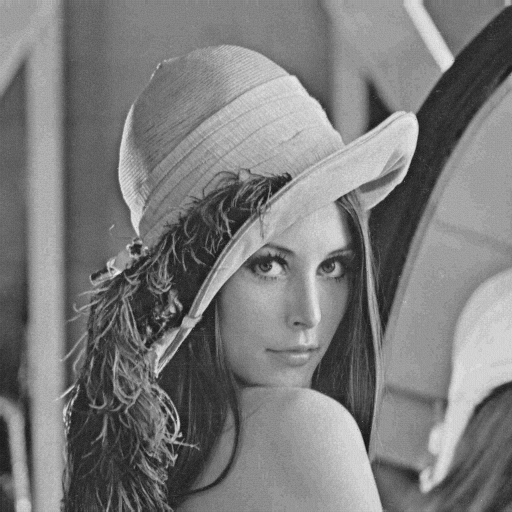

In [269]:
# tampered image with mean attact ..
cv2_imshow(modified_image)

In [270]:
_P2 = modified_image
# Divide matrix P into 2x2 blocks
blocks2 = divide_into_blocks(_P2)

# Shuffle blocks using a key string
key_string = "jD5r9H3pTcVuXzW6GvYtQx8P4eN1b2Sa"
shuffled_blocks2, shuffled_indices2 = shuffle_blocks(blocks2, key_string)

# Reverse the shuffle
unshuffled_blocks2 = unshuffle_blocks(shuffled_blocks2, shuffled_indices2)

# Reconstruct the original matrix P
reconstructed_P2 = combine_blocks(unshuffled_blocks2, P2.shape)

_p = combine_blocks(shuffled_blocks, P.shape)
_p2= shuffled_blocks

In [271]:
pz2 = [] # integer matrix for modified attacked image
pf2 = [] # decimal matrix for modified attacked image

# Iterate over each block in _p2
for block in _p2:
    # Extract integer and decimal parts
    integer_part = np.array(block, dtype=int)
    decimal_part = block - integer_part

    # Append integer and decimal parts to respective lists
    pz2.append(integer_part)
    pf2.append(decimal_part)

In [272]:
def detect_tampered_areas(image, attacked_coordinates):
    tampered_areas_image = np.ones_like(image, dtype=np.uint8) * 255  # Initialize image with ones (white)

    # Mark the attacked coordinates as black (0)
    for coord in attacked_coordinates:
        x, y = coord
        tampered_areas_image[y, x] = 0

    return tampered_areas_image

In [273]:
def detect_tampered_areas2(image, attacked_coordinates, processed_blocks):
    height, width = image.shape
    block_size = 2

    # Initialize tampered areas image with ones (white) of the same size as the original image
    tampered_areas_image = np.ones((height, width), dtype=np.uint8) * 255

    # Divide the image into blocks
    blocks = []
    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = image[y:y+block_size, x:x+block_size]
            blocks.append(block)

    # Mark the attacked blocks as black (0)
    for coord in attacked_coordinates:
        x, y = coord
        block_x = x // block_size
        block_y = y // block_size
        tampered_areas_image[y, x] = 0

    extracted_blocks = []
    for block in processed_blocks:
        auth_watermark_old = average_of_msb_block(block)  # Get the previously obtained authentication watermark
        feature_watermark_old = feature_watermark(block)  # Get the previously obtained feature watermark

        auth_watermark_new = extract_auth_watermark(block)  # Extract authentication watermark from the block
        feature_watermark_new = extract_feature_watermark(block)  # Extract feature watermark from the block

        # Compare the extracted watermarks with the previously obtained ones
        if auth_watermark_new == auth_watermark_old and feature_watermark_old == feature_watermark_new :
            # If both watermarks match, make the block 0
            extracted_blocks.append(False)
        else:
            # If watermarks don't match, make the block dark (set all values to 0)
            extracted_blocks.append(True)



    return tampered_areas_image, extracted_blocks


In [274]:
# finding tampered regions direcly and with the help of watermark based method ...
tampered_areas = detect_tampered_areas(modified_image, changeidx)
tampered_areas2,extracted = detect_tampered_areas2(modified_image, changeidx, pz2)


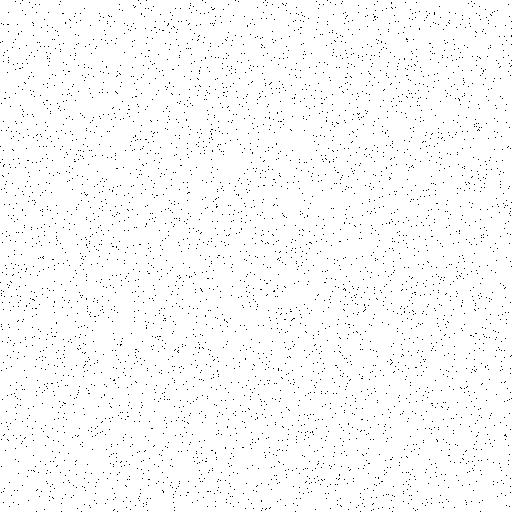

In [275]:
cv2_imshow(tampered_areas)

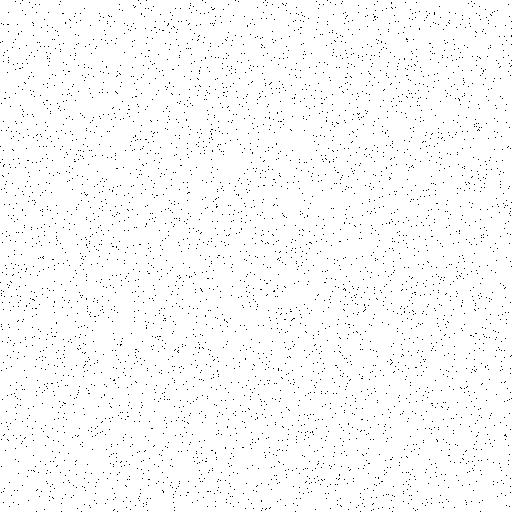

In [276]:
cv2_imshow(tampered_areas2)

In [277]:
psnr_grayscale(tampered_areas, tampered_areas2)


inf

In [278]:
ncc(tampered_areas, tampered_areas2)

array([1.])

In [279]:
# number of pixels which are different in 2 images ..
def image_difference(image1, image2):
    # Check if both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Both images must have the same shape.")

    # Initialize the difference count
    diff_count = 0

    # Iterate through each pixel in the images and compare their values
    for y in range(image1.shape[0]):
        for x in range(image1.shape[1]):
            if image1[y, x] != image2[y, x]:
                diff_count += 1

    return diff_count


In [280]:
# Assuming image1 and image2 are grayscale images of the same size
diff_count = image_difference(tampered_areas, tampered_areas2)
print("Difference count:", diff_count)


Difference count: 0


# 4. Recovering the Tampered Regions

In [281]:
# Function for recovery of original blocks based on tampered block ...
def recover_tampered_block(processed_blocks):
    recovered_blocks = []

    for block in processed_blocks:
        # Extract authentication and feature watermarks
        auth_watermark = extract_auth_watermark(block)
        feature_watermark = extract_feature_watermark(block)

        # Calculate diff and ans from the feature watermark
        diff = int(feature_watermark, 2) % 32
        ans = int(feature_watermark, 2) // 32

        # Determine positions of higher and lower values in the block
        high1 = (int(auth_watermark, 2) * 16) + ((diff + 1) // 2)
        high2 = (int(auth_watermark, 2) * 16) + (diff - ((diff + 1) // 2))
        low1 = int(auth_watermark, 2) * 16
        low2 = int(auth_watermark, 2) * 16

        # Modify the block values based on ans
        if ans == 1:
            modified_block = [[low1, low2], [high1, high2]]
        elif ans == 2:
            modified_block = [[low1, high1], [low2, high2]]
        elif ans == 3:
            modified_block = [[high1, low1], [high2, low2]]
        elif ans == 4:
            modified_block = [[high1, high2], [low1, low2]]
        elif ans == 5:
            modified_block = [[high1, low1], [low2, high2]]
        elif ans == 6:
            modified_block = [[low1, high1], [high2, low2]]
        else:
            # If ans is not in the range [1, 6], keep the block unchanged
            modified_block = block

        recovered_blocks.append(modified_block)

    return recovered_blocks


In [282]:
#  extract the watermark and store into blocks of array ..
_pz2 = extract_watermarked_blocks(pz2)
__pz2 = recover_tampered_block(pz2)

In [283]:
# convert the tupple of blocks into the matrix
reconstructed__P2 = combine_blocks(__pz2, P2.shape)

In [284]:
# use inverse wavelet transformation
_o2 = reverse_process_image(reconstructed__P2)

In [285]:
final_image, recover_block = recover_images(_o2, modified_image, pz2 )

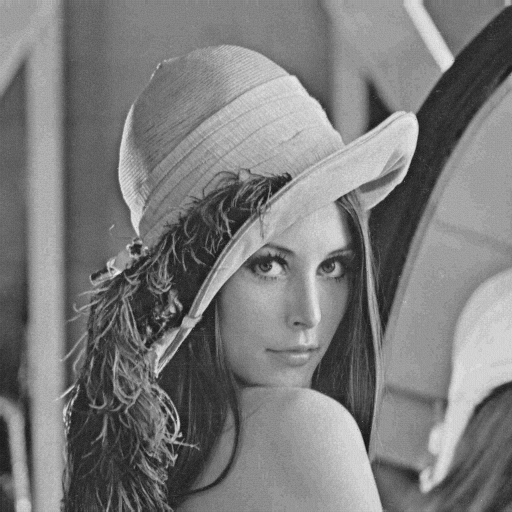

In [286]:
# final recovered Image ...
cv2_imshow(final_image)

In [287]:
print(final_image.shape)

(512, 512)


In [288]:
print(final_image.shape)

(512, 512)


In [289]:
# PSNR between the original image and watermark recover image
psnr_grayscale(gray_leena, final_image)

36.139372080939246

In [290]:
# NCC between the original image and watermark recover image
ncc(gray_leena,_o)

array([0.99678702])

# Recover the color image

In [291]:
# Check the image depth , if this step is not done then we cant convert it into its original color form ...
if final_image.dtype != np.uint8:
    final_image = cv2.convertScaleAbs(final_image)

In [292]:
final_color_image =  cv2.cvtColor(final_image, cv2.COLOR_GRAY2BGR)

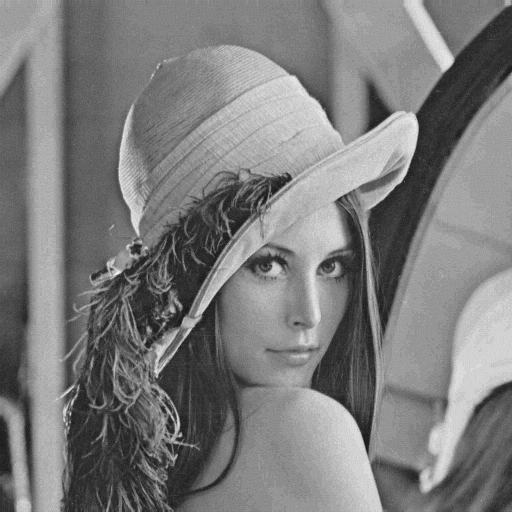

In [293]:
# final recovered color Image ...
cv2_imshow(final_color_image)

In [294]:
print(final_color_image.shape) # it has 3 channels so it is BGR image ..

(512, 512, 3)


In [295]:
# PSNR between the original color image and watermark recover color image
psnr_grayscale(final_color_image, leena)

15.782154703317229

In [296]:
# NCC between the original color image and watermark recover color image
ncc(final_color_image, leena)

array([0.72107056])